## 15.5 The Ising Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numba

The *Ising* model was developed to study phase transistion from a paramagnent to a ferromagnet.

- Consider a lattice of $N$ sites. 
- At each site is a number $s_i = \pm 1$ (spins).

The total energy $E$ for the Ising model is

$$E = -J \sum_{i, j = {\text n \text n}(i)}^N s_i s_j - B \sum_{i=1}^N s_i$$

- $B$ is proportional to the uniform external magnetic field
- $J$ is *exchange constant* and measures the strength between nearest neighbour spins.

The energy is given by the 1) interaction between the magnetic moments of the spins and 2) the external magnetic field.

See figure 15.1

We want the properties of an infinite system so choose periodic boundary conditions. A one-dimension lattice becomes a ring with spins at sites 1 and $N$ interacting as nearest neighbours.

Physical quantities to measure

1.  *magnetization* M given by

$$ M = \sum_{i=1}^N s_i$$

2. magnetization per spin

$$ m = M/N $$

We usually want the average values $\langle M \rangle$ and the fluctuations $\langle M^2 \rangle - \langle M \rangle^2$.

The dynamics of this system are not given by time-dependent laws (as would be the case of an ideal gas with Newton's Laws).  Here, the dynamics will take the form of various Monte Carlo algorithms.

### Demon algorithm

1. Choose a spin at random.
2. Trial changes flips spin from $\uparrow$ to $\downarrow$ or  $\downarrow$ to $\uparrow$.
2. Compute $\Delta E$, the change in the energy of the system due to the change.
3. If $\Delta E \le 0$, the system gives the amount $| \Delta E|$ to the demon, that is, $E_d = E_d - \Delta E$, and the trial configuration is accepted.
4. If $\Delta E \gt 0$ and the demon has sufficient energy for this change ($E_d \ge \Delta E)$, then the demon gives the necessary energy to the system, that is, $E_d = E_d - \Delta E$, and the trial configuration is accepted. Otherwise, the trial configuration is rejected and the configuration is not changed.

### Temperature

Two ways to measure temperature

1. Since $P(E_d) \propto e^{-E_d/kT}$, determine $T$ from the slope of the logarithm of the probabilty as function of $E_d$.

or

2. Measure mean demon energy. If $B=0$, it can be shown (see Appendix 15A) that

$$ kT/J = \frac{4}{\ln (1+4J/\langle E_d \rangle)}$$

### Implementation

Start first with the case $B=0$ (no external magnetic field) and $J=1$ (lowest energy state will be *ferromagnetic*).

We need a lattice of spins `s` with `N` elements.

In [381]:
N = 20

# start with all spins up
s = np.ones(N)

In [382]:
s

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

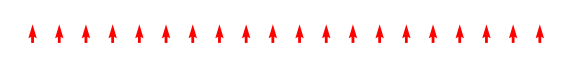

In [383]:
def plotSpins(s):
    plt.figure(figsize=(10,1))
    x = np.arange(N)
    y = np.zeros(N)
    width = 0.005
    scale = 30
   # plt.quiver(x, y, y, s, pivot='mid', width=width, scale=scale)
    plt.quiver(x[s>0], y[s>0], y[s>0], s[s>0], pivot='mid',
               width=width, scale=scale, color='red')
    plt.quiver(x[s<0], y[s<0], y[s<0], s[s<0], pivot='mid',
               width=width, scale=scale, color='green')
    plt.axis('off')

plotSpins(s)

Compute energy

$$E = -J \sum_{i, j = {\text n \text n}(i)}^N s_i s_j - B \sum_{i=1}^N s_i$$

In [384]:
def computeE(s):
    J = 1
    B = 0
    
    E = 0
    for i in range(N):
        E += - J * s[i] * s[(i+1)%N]  - B * s[i]
    return E

E = computeE(s)
E

-20.0

Compute magnetization
$$ M = \sum_{i=1}^N s_i$$

In [385]:
def computeM(s):
    M = np.sum(s)
    return M

M = computeM(s)
M

20.0

In [386]:
# system starts in ground state 
E = -N

# all spins are up initially
M = N 

Pick a random spin

In [387]:
k = np.random.randint(N)
k

1

Compute energy change

In [388]:
dE = 2*s[k]*(s[(k+1) % N] + s[(k-1) % N])
dE

4.0

Since `dE > 0`, flip it

In [389]:
s[k] *= -1

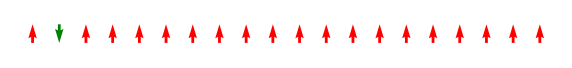

In [390]:
plotSpins(s)

Compute new energy

In [391]:
E += dE
E

-16.0

(checking we've calculated the systemEnergy correctly)

In [392]:
computeE(s)

-16.0

Compute new magneitization

In [393]:
M += 2*s[k]
M

18.0

(checking we've calculate the magnetization correctly)

In [394]:
computeM(s)

18.0

Note that the system energy is not continous, but is in discrete units of $\pm 4 J$.

To initialize the system with a desired system energy, we need to try several different initial configurations to find one that is close to the desired system energy.

In [395]:
## desired system energy
systemEnergy = -10

tries = 0
while (E < systemEnergy) and (tries < 10*N):
    k = np.random.randint(N)
    dE = 2*s[k]*(s[(k+1) % N] + s[(k-1) % N])
    
    if (dE > 0):
        s[k] *= -1
        E += dE
        M += 2*s[k]
        
    tries += 1

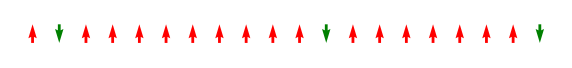

In [396]:
plotSpins(s)

In [397]:
tries

2

In [398]:
E

-8.0

In [399]:
# set the actual system energy
systemEnergy = E
demonEnergy = 0

Variables to track the history of the simulation

In [411]:
# reset()
mcs = 0
acceptedMoves = 0
systemEnergyHistory = []
demonEnergyHistory = []
magnetizationHistory = []

Monte Carlo steps

In [412]:
steps = 10
for i in range(steps):
    # do one MC step
    for j in range(N):
        k = np.random.randint(N)
        dE = 2*s[k]*(s[(k+1) % N] + s[(k-1) % N])

        if dE < demonEnergy:
            s[k] *= -1
            acceptedMoves += 1
            systemEnergy += dE
            demonEnergy -= dE
            M += 2*s[k]

    systemEnergyHistory.append(systemEnergy)
    demonEnergyHistory.append(demonEnergy)
    magnetizationHistory.append(M)
    mcs += 1

N = 20
mcs = 10
acceptedMoves = 70
systemEnergy = -12.0
demonEnergy = 4.0
magnetization = -10.0


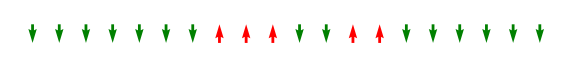

In [413]:
print(f'N = {N}')
print(f'mcs = {mcs}')
print(f'acceptedMoves = {acceptedMoves}')
print(f'systemEnergy = {systemEnergy}')
print(f'demonEnergy = {demonEnergy}')
print(f'magnetization = {M}')
plotSpins(s)

Now that we have the pieces of the algorithm worked out, combine them into a single class:

In [296]:
class IsingDemon():
    def __init__(self, N, systemEnergy):
        
        self.N = N
        
        # initialize to all spins being up
        self.s = np.ones(self.N)
        
        # system starts in ground state 
        E = -self.N

        # all spins are up initially
        M = self.N 
        
        # try to 10*N times to flip spins to that system has desired energy
        tries = 0
        while (E < systemEnergy) and (tries < 10*self.N):
            k = np.random.randint(self.N)
            dE = 2*self.s[k]*(self.s[(k+1) % self.N] +
                              self.s[(k-1) % self.N])

            if (dE > 0):
                self.s[k] *= -1
                E += dE
                M += 2*self.s[k]

            tries += 1
            
        self.systemEnergy = E
        self.demonEnergy = 0
        self.M = M
        
        self.reset()

    def reset(self):
        
        self.mcs = 0
        self.acceptedMoves = 0

        self.systemEnergyHistory = []        
        self.demonEnergyHistory = []
        self.magnetizationHistory = []

    def __str__(self):
        return f'''mcs = {self.mcs}
acceptedMoves = {self.acceptedMoves}
N = {self.N}
systemEnergy = {self.systemEnergy}
demonEnergy = {self.demonEnergy}
magnetization = {self.M}'''
    
    def __repr__(self):
        return self.__str__()
        
    def plotSpins(self):
        plt.figure(figsize=(10,1))
        x = np.arange(self.N)
        y = np.zeros(self.N)
        width = 0.005
        scale = 30
        
        up = self.s > 0
        dn = self.s < 0
        plt.quiver(x[up], y[up], y[up], self.s[up], pivot='mid',
                   width=width, scale=scale, color='red')
        plt.quiver(x[dn], y[dn], y[dn], self.s[dn], pivot='mid',
                   width=width, scale=scale, color='green')
        plt.axis('off')
        
    def show(self, bins=20):
        print(self)

        self.plotSpins()
        
        plt.figure(figsize=(8,6))
        
        plt.subplot(2,1,1)
        plt.plot(self.demonEnergyHistory)
        plt.ylim(ymin=0)
        plt.ylabel('$E_d$')
        
        plt.subplot(2,1,2)
        plt.plot(self.magnetizationHistory)

        plt.ylabel('$M$')
        plt.xlabel('mcs')
        
    def histogram(self):
        plt.figure(figsize=(8,8))
        plt.subplot(2,1,1)
        ΔEd = 4
        hist, bins = np.histogram(self.demonEnergyHistory, 
                                  bins=np.arange(0, 40, ΔEd)
                                 )
        P = hist/np.sum(hist)/ΔEd
        Ed = bins[:-1]
        plt.plot( Ed, P, 'o-')
        plt.xlabel('$E_d$')
        plt.ylabel('$P(E_d)$')

        
        plt.subplot(2,1,2)
        plt.hist(self.magnetizationHistory, bins=20)
        
        plt.xlabel('$M$')
        
        meanEd = np.mean(self.demonEnergyHistory)
        plt.figtext(0.75, 0.8, f'$\\langle E_d \\rangle$ = {meanEd:.2f}')
        meanM = np.mean(self.magnetizationHistory)
        plt.figtext(0.75, 0.4, f'$\\langle M \\rangle$ = {meanM:.2f}')
        meanM2 = np.mean(np.asarray(self.magnetizationHistory)**2)
        plt.figtext(0.75, 0.35, f'$\\langle M^2 \\rangle$ = {meanM2:.2f}')
        
        
    def doStep(self):
    # do one MC step
        for j in range(self.N):
            k = np.random.randint(self.N)
            dE = 2*self.s[k]*(self.s[(k+1) % self.N] +
                              self.s[(k-1) % self.N])

            if dE < self.demonEnergy:
                self.s[k] *= -1
                self.acceptedMoves += 1
                self.systemEnergy += dE
                self.demonEnergy -= dE
                self.M += 2*self.s[k]

        self.systemEnergyHistory.append(self.systemEnergy)
        self.demonEnergyHistory.append(self.demonEnergy)
        self.magnetizationHistory.append(self.M)
        self.mcs += 1
        
    def doSteps(self, steps=1):
        for i in range(steps):
            self.doStep()
            

Explore behaviour for $E=-20$. Then explore with $E=-100$.

In [297]:
sim = IsingDemon(N=100, systemEnergy=-20)

mcs = 1
acceptedMoves = 61
N = 100
systemEnergy = -28.0
demonEnergy = 8.0
magnetization = 6.0


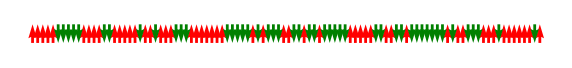

In [298]:
sim.doStep()
sim.plotSpins()
print(sim)

In [303]:
sim = IsingDemon(N=100, systemEnergy=-20)

Time series for $E_d$ and $M$.  Note time required to reach equilibrium.

In [304]:
sim.doSteps(1000)

mcs = 1000
acceptedMoves = 74209
N = 100
systemEnergy = -24.0
demonEnergy = 4.0
magnetization = 2.0


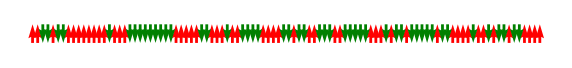

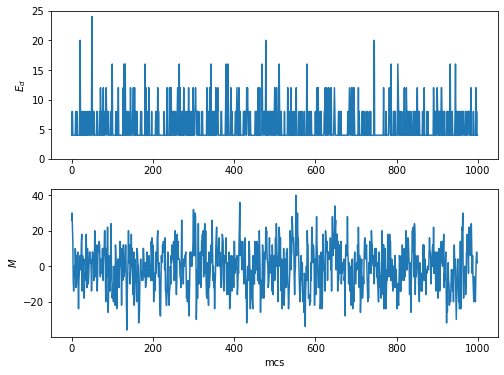

In [305]:
sim.show()

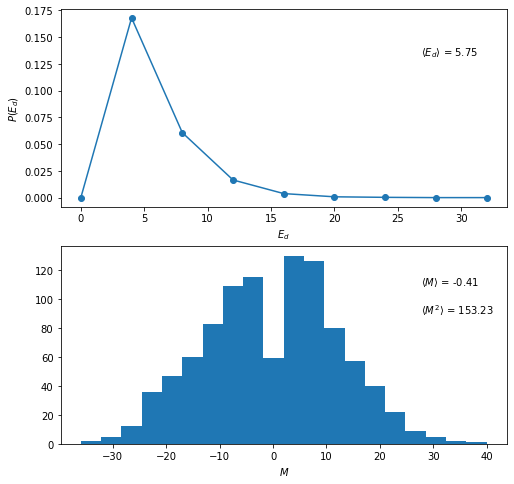

In [306]:
sim.histogram()